In [1]:
from collections import Counter
import pdb                          # For debugging
import os                           # For filesystem management
from multiprocessing import Pool    # For parallel execution
from IPython.display import HTML
from tqdm import tqdm               # For progress bars
import pickle
import primesieve
import Powerset
import numpy

from scipy.special import factorial2, gammaincc

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors, rc

from accessory import animate, animate_twopt, animate_slice_data

plt.rcParams.update({"text.usetex": True})

numpy.seterr(all='raise')

In [4]:
# The following directory tells the code where to store the generated configurations, By default use the directory
# that the code is run from
# If you change this make sure to leave a trailing backslash!
# base_directory = os.getcwd() + '/'
base_directory = "/mnt/drive1/Multilevel_data/"

# The animation writer to use
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

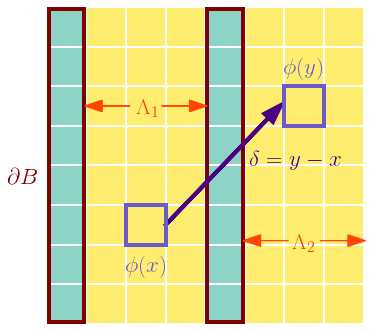

In [10]:
grid = numpy.zeros((8, 8))
grid[:, 0] = numpy.ones(8)
grid[:, 4] = numpy.ones(8)
grid = 1 - grid

plt.imshow(grid, cmap='Set3')

ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=2)
ax.set_xticks(numpy.arange(-.5, 8, 1))
ax.set_yticks(numpy.arange(-.5, 8, 1))

for xlabel_i in ax.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in ax.axes.get_xticklines():
    tick.set_visible(False)
for tick in ax.axes.get_yticklines():
    tick.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

x = plt.Rectangle((1.5, 4.5), 1, 1, color='slateblue', lw=4, zorder=100, fill=None)
y = plt.Rectangle((5.5, 1.5), 1, 1, color='slateblue', lw=4, zorder=100, fill=None)
plt.arrow(2.5, 5, 2.6, -2.7, lw=4, color='indigo', head_width=0.3, zorder=100)
plt.text(4.6, 3.5, r'$ \delta = y - x $', color='indigo', fontsize=23)
plt.text(1.5, 6.2, r'$ \phi (x) $', color='slateblue', fontsize=23)
plt.text(5.5, 1.2, r'$ \phi (y) $', color='slateblue', fontsize=23)

B1 = plt.Rectangle((-0.45, -0.45), 0.9, 7.9, color='maroon', lw=4, zorder=80, fill=None)
B2 = plt.Rectangle((3.55, -0.45), 0.9, 7.9, color='maroon', lw=4, zorder=80, fill=None)
plt.text(-1.5, 4, r'$ \partial B $', color='maroon', fontsize=23)

plt.text(1.75, 2.2, r'$ \Lambda_1 $', color='orangered', fontsize=23)
plt.arrow(2.4, 2, 0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.arrow(1.6, 2, -0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.text(5.7, 5.6, r'$ \Lambda_2 $', color='orangered', fontsize=23)
plt.arrow(6.4, 5.4, 0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.arrow(5.6, 5.4, -0.7, 0, color='orangered', zorder=100, head_width=0.3)


ax.add_patch(x)
ax.add_patch(y)
ax.add_patch(B1)
ax.add_patch(B2)

fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.savefig(f'{base_directory}graphs/multilevel_diagram.pdf')

plt.show()

The following function will be used repeatedly to check if simulation data already exists.

In [3]:
def file_exists(directory, file):
    files = os.popen(f'ls {directory}')
    files = [x[:-1] for x in files]  # Remove the '\n' charachter from filenames

    if file in files:
      return True

    else:
      return False

The following template functions are used to generate the filenames where data will be stored. They are defined here so that the filenames are used consistantly throughout the code.

In [4]:
def template_1_1(L, beta, N, initial, step, directory=False):
  if directory:
    return f"{base_directory}ising/L{L}/b{beta:.10f}/"

  else:
    return f"L{L}_b{beta:.10f}_N{N}_init{initial}_step{step}_spins_1_1.npy"
  
def template_splitting(L, beta, N, M, Mstep, source_file_N, source_file_init, source_file_step, Nstep, i, j):
  return f"L{L}_b{beta:.10f}_N{N}_M{M}_Mstep{Mstep}_sourceN{source_file_N}_sourceinit{source_file_init}_sourcestep{source_file_step}_Nstep{Nstep}_spins_{i}_{j}.npy"

def template_twopt(L, beta, N, initial, step, delta, directory=False):
  if directory:
    return f"{base_directory}twopt/single_slice/"

  else:
    return f"L{L}_beta{beta}_N{N}_step{step}_initial{initial}_delta{delta}.npy"

def template_twopt_bootstrap(L, beta, N, initial, step, delta, seed, no_samples, directory=False):
  if directory:
    return f"{base_directory}twopt/single_slice/"

  else:
    return f"L{L}_beta{beta}_N{N}_step{step}_initial{initial}_delta{delta}_seed{seed}_no_samples{no_samples}.npy"

def template_twopt_multi(L, beta, N, initial, delta, M, Mstep, Nstep, source_file_step, splitting, directory=False):
  if directory:
    return f"{base_directory}twopt/multi_slice/"

  else:
    return f"""L{L}_beta{beta}_N{N}_M{M}_source_step{source_file_step}_Nstep{Nstep}_Mstep{Mstep}_initial{initial}_delta{delta}_splitting{splitting}.npy"""

def template_twopt_multi_weighted(L, beta, N, M, source_file_step, Nstep, Mstep, initial, delta, no_samples, weights="optimized", seed=None, bin_size=1,                                           directory=False):
  if directory:
    return f"{base_directory}twopt_weighted/multi_slice/"

  else:
    if seed is None:
     return f"L{L}_beta{beta}_N{N}_M{M}_source_step{source_file_step}_Nstep{Nstep}_Mstep{Mstep}_initial{initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}_bin_size{bin_size}.npy"
    else:
      return f"L{L}_beta{beta}_N{N}_M{M}_source_step{source_file_step}_Nstep{Nstep}_Mstep{Mstep}_initial{initial}_delta{delta}_no_samples{no_samples}_weights{weights}_bin_size{bin_size}.npy"

def template_twopt_calculation(beta, L, N, M, no_samples, Nstep, Mstep, source_step, bin_size, seed, directory=False):
  if directory:
    return f"{base_directory}results/"
  else:
    return f"results_run_N{N}_M{M}_L{L}_Nstep{Nstep}_Mstep{Mstep}_source_step{source_step}_beta{beta}_no_samples{no_samples}_seed{seed}.npy"

# 1. The Ising Model
## 1.1. Utility Functions
In order to perform multilevel, we need a way to label the subregions of the lattice. region_maker is a generalized function that takes the sidelength of the lattice, L, and a tuple of the splitting, s, as inputs. Each element of s is the number of sublattices along a given direction, e.g. the s[0]=2 means that along the x-axis the lattice is split into 2. The number of dimensions is inferred by the lenghth of s. The boundary layers seperating the sub-lattices are labelled by 0, while the subregions are numbered 1, 2, ... . For example, region_maker(8, (2, )) returns $[0, 1, 1, 1, 0, 2, 2, 2]$.

In [5]:
def region_maker(L, s):
  """
    This function will return an array of the same shape as the lattice, called regions. This array
    uniquely labels all regions of the lattice, and labels the boundaries by 0.

    L : int, size of the lattice (Assumed to be the same size in all directions currently.)
    s : (n, ) tuple of ints, describing how the lattice is to be broken
      down in the directions (x1, ..., xn). The dimensionality of the lattice is inferred from the length of s
  """
  for i in s:
    assert type(i) == int, "The lattice must be divided into an integer number of subregions"
    assert i >= 1, "Components of s must be greater of equal to 1"
    assert L % i == 0, "The lattice size must divide exactly into the number of subregions"

  s = numpy.array(s, dtype=int)
  dim = len(s)
  shape = (L, ) * dim

  # The trivial case where there is no splitting of the lattice, simply label all sites as 1
  if numpy.product(numpy.array(s)) == 1:
    return numpy.ones(shape)

  regions = numpy.zeros(shape)
  indices = numpy.indices(shape).reshape(dim, L ** dim).T

  for i in range(len(indices)):
    x = indices[i]
    total = 0

    # Labels the subregion indices of this position
    R = x // (L // s)

    # 0 if on boundary, 1 if not
    B = numpy.product(numpy.where(s > 1,
                        numpy.where(x % (L // s), 1, 0),
                      1))

    for i in range(dim):
      total *= s[i]
      total += (R[i] + (i + 1) // dim) * B

    regions[tuple(x)] = total

  return regions


In [6]:
region_maker(8, (2, 2))

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 2., 2., 2.],
       [0., 1., 1., 1., 0., 2., 2., 2.],
       [0., 1., 1., 1., 0., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 3., 3., 3., 0., 4., 4., 4.],
       [0., 3., 3., 3., 0., 4., 4., 4.],
       [0., 3., 3., 3., 0., 4., 4., 4.]])

Let's check the region maker gives the expected output when splitting a 2D lattice into 4 quadrants, e.g. s = (2, 2)

In [7]:
assert numpy.array_equal(region_maker(8, (2, 2)),
                          numpy.array([[0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, 3, 3, 3, 0, 4, 4, 4],
                                       [0, 3, 3, 3, 0, 4, 4, 4],
                                       [0, 3, 3, 3, 0, 4, 4, 4]]))

In order to visualize what is coming it will be important to plot the spins nicely. The spin array elements will take values of +1 for spin up, and -1 for spin down. This function takes a matplotlib axis as input, as well as an array of spins, for the purpose of making movies later.

In [8]:
def plot_spins(spins, ax):
  L = spins.shape[0]

  # create discrete colormap
  cmap = colors.ListedColormap(['red', 'blue'])
  bounds = [-2, 0, 2]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  ax.imshow(spins, cmap=cmap, norm=norm)

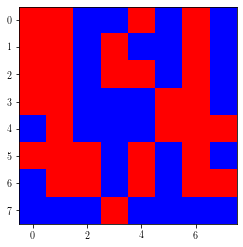

In [9]:
spin_test = numpy.random.randint(2, size=(8, 8)) * 2 - 1

fig, ax = plt.subplots()  # Create an empty figure

plot_spins(spin_test, ax)

plt.show()  # Display the figure

For the purpose of parrallelisation, the following function constructs a chessboard pattern over a lattice. This is only possible on lattices with even side lengths, because of periodic boundary conditions. This function is written for 2D though it could be extended to higher dimensions easily.

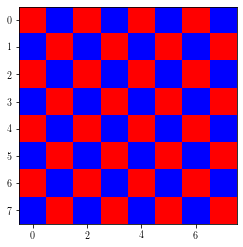

In [10]:
def chessboard_2D(L):
  board = numpy.zeros((L, L), dtype=int)
  for i in range(L):
    for j in range(L):
      board[i, j] = (i + j) % 2
  return board

fig, ax = plt.subplots()
plot_spins(chessboard_2D(8) * 2 - 1, ax)
plt.show()

In the Ising model the energy is given by
$H = -J \sum_{i, j n.n.}s_is_j - B\sum_i s_i$, where n.n. stands for nearest neighbours. We are therefore compelled to have an easy way to calculate the sum of the spins of nearest neighbours to a point.

In [11]:
def neighbour_total(spin_array):
  """
    This function takes an array of spins, and returns, at each position in
    the lattice, the total of the neighbouring spins to that lattice position.

    INPUTS :
    --------
    spin_array: numpy array object with entries of either 1 or (-1) as in
                initialise_problem function

    OUTPUTS :
    ---------
    total_neighbour_spin: an array of the same shape as the spin_array, but
                          at each lattice site is the total of the neighbouring
                          spins.
  """
  total_neighbour_spin = numpy.zeros(spin_array.shape)

  for dim in range(len(spin_array.shape)):
    total_neighbour_spin += numpy.roll(spin_array, 1, axis=dim)
    total_neighbour_spin += numpy.roll(spin_array, -1, axis=dim)

  return total_neighbour_spin

## 1. 2. Generating Configurations
We are now ready to construct the lattice object which will underlie our Ising model simulations.

In [12]:
class lattice(object):
  def __init__(self, L, splitting, beta=1, spins=None):
    """
        INPUTS :
        --------
        L : int, sidelength of lattice
        splitting : tuple of ints, the number of sublattices in each dimension
        beta : the inverse temperature, float
        spins : A given starting configuration of spins. If None then the starting configuration of spins will
            be generated randomly
    """
    assert L % 2 == 0, "L must be a mulitple of 2 for the chessboard method to be valid"

    if spins is None:
      spins = numpy.random.randint(0, 2, size=(L, L)) * 2 - 1

    else:
      self.spins = spins

    self.spins = numpy.array(spins, dtype=numpy.int8) # For reduced memory / harddrive usage
    self.chessboard = chessboard_2D(L)
    self.regions = region_maker(L, splitting)
    self.beta = beta

    # This is the total energy associated with all interactions at a point - to get the correct total energy
    # density this value should be halved, since interactions involve two sites
    self.energies = -self.spins * neighbour_total(self.spins)
    self.L = L

  def step(self):
    # Flip the white squares first (of the "chessboard")
    delta_E = -self.energies * 2  # The amount the energy will change if the spin flips
    
    # Using the metropolis algorithm
    jump_condition = numpy.exp(-self.beta * delta_E) > numpy.random.rand(self.L, self.L)

    # Flip a site if
    # 1. It passes the Metropolis-Hastings flip condition
    # 2. The site isn't on the boundary
    # 3. It is one of the squares on the chessboard being flipped
    to_flip = numpy.logical_and(jump_condition,
                    numpy.logical_and(self.regions, self.chessboard))

    self.spins = numpy.where(to_flip, -self.spins, self.spins)
    
    # Recalculate all site energies
    self.energies = -self.spins * neighbour_total(self.spins)

    # Now flip the black squares
    delta_E = -self.energies * 2
    jump_condition = numpy.exp(-self.beta * delta_E) > numpy.random.rand(self.L, self.L)

    to_flip = numpy.logical_and(jump_condition,
                    numpy.logical_and(self.regions, numpy.logical_not(self.chessboard)))

    self.spins = numpy.where(to_flip, -self.spins, self.spins)
    self.energies = -self.spins * neighbour_total(self.spins)

The following function generates N configurations of an Ising Model simulation on the whole lattice (no subdivisions). It is named with '1_1', because you can think of a lattice with no subdivisions as being constructed from 1x1 sublattices.

In [13]:
def generate_states_1_1(L, beta, N, step, initial, rerun=False, initial_spins=None):
  """
    INPUTS :
    --------
    L : int, sidelength of lattice
    beta : the inverse temperature, float
    N : Number of configurations to save in the esemble, int
    step : Number of update steps between configs, int
    initial : Thermalization steps - number of MH steps done before the first config is measured
    rerun : Bool, if True then rerun the generation even if a saved file with this ensemble is found
    initial_spins : A given starting configuration of spins. If None then the starting configuration of spins will
        be generated randomly
        
    OUTPUTS :
    ---------
    (N, L, L) numpy array of ints representing N spin configurations
  """
  # Save file location
  directory = template_1_1(L, beta, N, initial, step, directory=True)
  filename = template_1_1(L, beta, N, initial, step)

  if not rerun:
    if file_exists(directory, filename):
      return numpy.load(f"{directory}{filename}")
  
  # If the saved data is not found, or rerun==True then generate the data
  print(f"Generating states for : L = {L}, N = {N}, beta = {beta:.10f}, splitting = (1, 1)")
  data = numpy.zeros((N, L, L), dtype=numpy.int8)
  x = lattice(L, (1, 1), beta=beta, spins=initial_spins)

  # Perform the initial equillibriating steps of the Monte Carlo
  for j in range(initial):
    x.step()

  # Now start recording configurations
  for i in range((N - 1) * step + 1):
    if(i % step == 0):
      data[i // step] = x.spins

    x.step()

  # If the directory for data to be saved into doesn't exist then make it.
  if not os.path.isdir(directory):
    os.makedirs(directory)

  numpy.save(f"{directory}{filename}", data)

  return data

To generate ensembles with a split lattice the technique is very similar except for each of the N "higher-level" configurations, the configurations of the boundary spins are taken, and M multilevel states are produced from there.

In [14]:
def generate_states_splitting(L, beta, N, M, Mstep, splitting, source_file_N, source_file_init,
                              Nstep=1, source_file_step=True, rerun=False):
  """
    INPUTS :
    --------
    L : size length, int
    beta : inverse temperature, float
    N : Number of boundary configurations
    M : Number of sublattice configs per boundary
    Mstep : Number of update steps between sublattice configs
    splitting : (2, ) tuple of ints giving the number of lattice splittings in each direction
    source_file_N : Number of configs in base single level simulation data, int
    Nstep : Number of configs from source between boundary configs,  e.g. if
      the source file keeps every 10th lattice state and Nstep is 2, then every
      other saved config is used as a starting point for the sublattice simulation,
      e.g. every 20th iteraction of the source algorithm. int
    source_file : the name of the file containing the starting boundary configurations
    source_file_step : number of updates per config used to generate single level data, 
        if true set to the same as Mstep
    
    OUTPUTS :
    ---------
    data : (N, M, L, L) numpy array of {-1, 1} representing the spin configurations
  """
  i, j = splitting[0], splitting[1]

  if source_file_step:
    source_file_step = Mstep

  directory = template_1_1(L, beta, source_file_N, source_file_init, source_file_step, directory=True)
  filename = template_splitting(L, beta, N, M, Mstep, source_file_N, source_file_init, source_file_step, Nstep,
                                i, j)

  # This is the file of single level data used to construct multilevel data
  source_file = template_1_1(L, beta, source_file_N, source_file_init, source_file_step)
  
  if not rerun:
    if file_exists(directory, filename):
      return numpy.load(f"{directory}{filename}")

  # If the saved data is not found, or rerun==True then generate the data
  data = numpy.zeros((N, M, L, L), dtype=numpy.int8)
  
  # Check if the source file exists
  if not file_exists(directory, source_file):
    print("No source configuration files - generating these first")
    generate_states_1_1(L, beta, source_file_N, source_file_step, source_file_init, rerun=False)

  # Load in N configs from source file in steps of Nstep
  source_data = numpy.load(f"{directory}{source_file}")[0:Nstep * N:Nstep]

  print(f"Generating states for : L = {L}, N = {N}, M = {M}, beta = {beta:.10f}, splitting = ({i}, {j})")

  for k in range(N):
    print('.', end='')
    # Use the spin configurations from the single level data as starting points
    x = lattice(L, splitting, beta=beta, spins=source_data[k])

    for l in range((M - 1) * Mstep + 1):
      if l % Mstep == 0:
        data[k, l // Mstep] = x.spins

      x.step()

  numpy.save(f"{directory}{filename}", data)

  return data

## 1. 3. Visualization
To check that the system is behaving as expected, the following movie function that will iterate through some of this multilevel data, showing the evolution of the spin array.

High temperature single level. The boundary layers are highlighted, however, for a single level algorithm they are equivalent to non-boundary sites. They are shown for easy comparison to the later multilevel example.

In [15]:
# data = generate_states_1_1(16, 0.4, 100, 1, 1, rerun=False, initial_spins=None)

# anim = animate(data, 100, 0.1, save_fig=False, filename=None,
#             show_fig=True)

# anim.save('single_level_spin_movie.gif', dpi=500)
# print(matplotlib.rcParams)
# rc('animation', html='html5')

# HTML(anim.to_html5_video())

And now let us study the effects of the boundary. In the following video, N=10 and M=10, so there are 10 boundary configurations and 10 sublattice updates per boundary. I will use the previous configs as a source of boundary configs.

In [16]:
# data = generate_states_splitting(16, 0.4, 10, 10, 1, (2, 2), 100, 1)

# anim = animate(data.reshape((10, 10, 16, 16)), 100, 0.2, save_fig=False, filename=None,
#             show_fig=True)
               
# anim.save('multi_level_spin_movie.gif', dpi=500)
# rc('animation', html='html5')

# HTML(anim.to_html5_video())

Note that for a smoother animation a step size of 1 was used. However, because of autocorrelations it is often necessary to use a larger step size. I found in this project that a step size of 20 gave acceptable results.

# 2. Slice Variables
In this section we look at the slice variable framework, where a slices of the lattice is used as representatives of the full lattice. It can be shown that this approach preserves the two-point functional form. [reference?!].
## 2.1. Utility Functions

In [17]:
def chisq_pvalue(k, x):
  """
  INPUTS :
  --------
  k : int, the rank (number of degrees of freedom)
  x : float, the chi-sq value
  
  RETURNS :
  ---------
  chisq_pvalue : float, pvalue of chisq fit
  """
  return gammaincc(k / 2, x / 2)

## 2.2. Implementing slice classes
### 2.2.1 Single Level

single_slice_ising:
    twopt(delta) : Function evaluating the two-point function depending on the distance between two points, delta.
    xi_cosh_fit(no_samples) : Find the correlation length and its error through fitting a cosh function to the two-point data, and performing a statistical bootstrap.

In [19]:
class single_slice_ising:
  def __init__(self, L, beta, N, step, initial=1000, rerun_generation=False):
    """
        INPUTS :
        --------
        L : side length, int
        beta : inverse temperature, float
        N : Number of boundary configurations, int
        step : Number of update steps between configs, int
        initial : Number of initial configs that go unsaved, so that the system can reach equillibrium, int
        rerun_generation : Bool, if True then source files will be regenerated regardless of whether
            save files are found
    """
    # Generate or load in relevent configuration
    self.spins = generate_states_1_1(L, beta, N, step, initial, rerun=rerun_generation)

    # Average over one of the spatial dimensions of the lattice
    self.spin_slice = numpy.mean(self.spins, axis=2)
    self.beta = beta
    self.L = L
    self.N = N
    self.initial = initial
    self.step = step
    self.rerun_generation = rerun_generation
    
    # twopt_values is a dictionary because each delta (seperation between lattice sites) has an entry.
    self.twopt_values = {}

  def twopt(self, delta):
    """
      Function that calculates the value of the two-point with a seperation of magnitude delta.
      
      INPUTS :
      --------
      delta: seperation distance, int
      
      RETURNS :
      ---------
      twopt : (N, ) numpy array of floats, with each entry being the twopt value on a given configuration
    """
    # As algorithm is deterministic, then one can choose to load the results from a save file
    directory = template_twopt(self.L, self.beta, self.N, self.initial, self.step, delta, directory=True)
    filename = template_twopt(self.L, self.beta, self.N, self.initial, self.step, delta)

    # Check if the data already exists (only if rerun_generation is False)
    if not self.rerun_generation:
      if file_exists(directory, filename):
        twopt = numpy.load(f"{directory}{filename}")
        self.twopt_values[delta] = twopt
        return twopt

    twopt = self.spin_slice * numpy.roll(self.spin_slice, -delta, axis=1)

    # Make the save directory if it doesn't already exist
    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", twopt)

    return twopt

  def twopt_bootstrap(self, delta, no_samples, seed=0, rerun=False):
    # As algorithm is deterministic, then one can choose to load the results from a save file
    directory = template_twopt_bootstrap(self.L, self.beta, self.N, self.initial, self.step, delta, seed, no_samples, directory=True)
    filename = template_twopt_bootstrap(self.L, self.beta, self.N, self.initial, self.step, delta, seed, no_samples)

    # Check if the data already exists (only if rerun_generation is False)
    if not self.rerun_generation:
      if file_exists(directory, filename):
        twopt = numpy.load(f"{directory}{filename}")
        self.twopt_values[delta] = twopt
        return twopt

    # Set the seed if given as an argument
    if seed:
      numpy.random.seed(seed)

    # Load in the twopt calculations
    twopt = numpy.mean(self.twopt(delta), axis=1)

    # Perform a bootstrap
    bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))
    result = numpy.zeros(no_samples)

    for i in range(no_samples):
      result[i] = numpy.mean(twopt[bootstrap[i]])
      
    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", result)

    return result

Let's have a look at an example. Below we consider a L=8 square lattice. We will consider the two-point correlator of points seperated by a distance of 5. The animation has 4 subplots:

1. The spin array
2. The slice variables, which are just averaged in the vertical direction
3. The slice variables, shifted by delta
4. The twopt function, which is the product of the slice variables and the shifted slice variables. This is should then averaged to get the actual value of the twopt function

In [20]:
# data = single_slice_ising(8, 0.2, 100, 1)

# anim = animate_twopt(data, 100, 1, 5)

# anim.save('slice_twopt.gif', dpi=500)

# rc('animation', html='html5')

# HTML(anim.to_html5_video())

### 2.2.2. Multilevel

Before we get the full class defintion we need the following accessary function. This is a first pass attempt to find the weighting scheme we should use when constructing weighted averages in a multilevel scheme. 

In [21]:
def naiive_weights(L, splitting, delta, M):
  """
    INPUTS :
    --------
    L : int, sidelength of the lattice
    splitting : int, number of sublattices in the remaining dimension after slice-averaging
    delta : the displacement along the slice direction
    M : int, Number of sublattice updates per boundary update
    
    RETURNS :
    ---------
    (L, ) numpy array of float/int, whereby if a twopt function goes between two boundaries it has a weight of 1, 
        while if it's between a boundary and a subregion, or between two points in the same subregion, it is M,
        and if it's between two different subregions, it has a weight of M ** 2
  """
  # Set all the weights to M
  xweights = numpy.ones(L) * M

  # Set boundaries to 1
  xweights[::L // splitting] = 1

  # Roll this to get calculate weights at second point, y
  yweights = numpy.roll(xweights, -delta)

  # Calculate the regions
  xregions = region_maker(L, (splitting, ))

  # roll this to get regions for second point
  yregions = numpy.roll(xregions, -delta)

  # Use this to determine weights
  weights = numpy.where(xregions != yregions, xweights * yweights, xweights)

  return weights[:L//splitting]

Let's look at an example: An L = 12 lattice, divided into two. Let's first consider a two-point function of delta = 6. This means that all contributions, except those of the boundary, benefit from multilevel, and so get an M^2 weight, while the boundary has a weight of 1.

Note also that there are only 6 values given in the output. This is because the lattice is translationally invariant under a shift of the size of the sublattice, so the weights associated with x in {0, 5} are the same as those with x in {6, 11}

In [22]:
naiive_weights(12, 2, 6, 10)

array([  1., 100., 100., 100., 100., 100.])

Now consider a two-point seperation of 2, meaning that only two-point functions involving lattice sites directly adjacent to the boundary will benefit from Multilevel.

In [23]:
naiive_weights(12, 2, 2, 10)

array([ 10.,  10.,  10.,  10.,  10., 100.])

If we were to try and do something similar for a multilevel system the result would be like the following. The following class is quite large, so will be explained gradually as this document progresses.

In [24]:
class multi_slice_ising:
  def __init__(self, L, beta, N, M, splitting, Mstep=100, initial=1000, Nstep=1, source_file_step=100, rerun_generation=False):
    self.spins = generate_states_splitting(L, beta, N, M, Mstep, (splitting, 1), N * Nstep, initial, Nstep=Nstep, source_file_step=source_file_step,                                                        rerun=rerun_generation)
    self.spin_slice = numpy.mean(self.spins, axis=3)
    self.beta = beta
    self.L = L
    self.N = N
    self.initial = initial
    self.Mstep = Mstep
    self.Nstep = Nstep
    self.M = M
    self.Nstep = Nstep
    self.source_file_step = source_file_step
    self.rerun_generation = rerun_generation
    self.regions = region_maker(L, (splitting, ))
    self.twopt_values = {}
    self.splitting = splitting
    
  def twopt_raw(self, delta):
    """
      For educational purposes. Calculates the twopt function at each slice variable, on all (N, M) configs seperately
      returning an (N, M, L) shape array
    """
    x_slice = self.spin_slice
    y_slice = numpy.roll(x_slice, -delta, axis=2)
    twopt_raw = x_slice * y_slice

    return twopt_raw

  def twopt(self, delta):
    directory = template_twopt_multi(self.L, self.beta, self.N, self.initial, delta, self.M, self.Mstep, self.Nstep,                                                                                                self.source_file_step, self.splitting, directory=True)
    filename = template_twopt_multi(self.L, self.beta, self.N, self.initial,  delta, self.M, self.Mstep, self.Nstep,                                                                                                self.source_file_step, self.splitting, directory=False)
    if not self.rerun_generation:
      if file_exists(directory, filename):
        twopt = numpy.load(f"{directory}{filename}")
        self.twopt_values[delta] = twopt
        return twopt
      
    # Calculate the twopt function for each value of N first
    x_slice = self.spin_slice
    regions = self.regions

    y_slice = numpy.roll(x_slice, -delta, axis=2)
    y_regions = numpy.roll(regions, -delta)

    # Multilevel product
    combinatoric_av = numpy.zeros((self.N, self.L))
    for i in range(self.M):
      for j in range(self.M):
        combinatoric_av += x_slice[:, i, :] * y_slice[:, j, :] / (self.M) ** 2
    
    # For twopt correlators where multilevel isn't valid
    within_region = x_slice * y_slice
    within_region_av = numpy.mean(within_region, axis=1)  # Average over sublattice axis

    # Perform a multilevel product where applicable (2 sites in different subregions)
    twopt = numpy.where(regions != y_regions, combinatoric_av, within_region_av)

    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", twopt)

    self.twopt_values[delta] = twopt

    return twopt

  def twopt_weighted(self, delta, no_samples, seed=False, weights="optimized", rerun=False, bin_size=1):
    directory = template_twopt_multi_weighted(self.L, self.beta, self.N, self.M, self.source_file_step, self.Nstep, self.Mstep, self.initial, delta,                                                      no_samples, weights=weights, seed=seed, bin_size=bin_size, directory=True)
    filename = template_twopt_multi_weighted(self.L, self.beta, self.N, self.M, self.source_file_step, self.Nstep, self.Mstep, self.initial, delta,                                                      no_samples, weights=weights, seed=seed, bin_size=bin_size, directory=False)

    if not self.rerun_generation:
      if file_exists(directory, filename):
        result = numpy.load(f"{directory}{filename}")
        return result

    # Set the seed if given as an argument
    if seed:
      numpy.random.seed(seed)

    # Calculate bootstrap samples for each set
    bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))
    result = numpy.zeros(no_samples)

    # Load in the twopt calculations pre bootstrap
    twopt = self.twopt(delta)

    # Symmetrize over the subregions
    twopt = twopt.reshape(self.N, self.splitting, self.L // self.splitting)
    twopt = numpy.mean(twopt, axis=1)

    for i in range(no_samples):
      # Randomly shuffle the configs
      twopt_sample = twopt[bootstrap[i]]

      if weights == 'optimized':
        # Number of bins used for caclulation of the weights
        assert self.N % bin_size == 0, "The bin number must exactly divide N"
        no_bins = self.N // bin_size

        for j in range(no_bins):
          # Extract all data except one bin, and seperately just that bin
          twopt_sample_rest = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size != j]
          twopt_sample_bin = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size == j]

          # Caclulate the covariance matrices for each set, and normalize it's determinant to 1
          cov_matrix = numpy.cov(twopt_sample_rest, rowvar=False)
          cov_matrix = cov_matrix / (numpy.linalg.det(cov_matrix)) ** (1 / cov_matrix.shape[0])

          # Invert the matrix and use this to caclulate the weights
          cov_inv = numpy.linalg.inv(cov_matrix)
          weights_vector = numpy.sum(cov_inv, axis=1)

          # Normalieze the weights
          weights_vector = weights_vector / numpy.sum(weights_vector)

          # Use the weights of one group to find the average of another
          result[i] += numpy.mean(numpy.average(twopt_sample_bin, weights=weights_vector, axis=1)) / no_bins

      if weights == 'naiive':
        weights_vector = naiive_weights(self.L, self.splitting, delta, self.M)

        result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights_vector, axis=1))

      if weights == 'equal':
        weights_vector = numpy.ones(self.L // self.splitting)

        result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights_vector, axis=1))

    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", result)
    
    return result

In [25]:
# data = multi_slice_ising(8, 0.2, 10, 10, 2)

# anim = animate_twopt(data, 100, 1, 4, multilevel=True)

# anim.save('slice_twopt_multi.gif', dpi=500)

# rc('animation', html='html5')

# HTML(anim.to_html5_video())

One thing that you may notice in the video above is that the contribution to the twopt function between the boundariess doesn't change when the sublattices are resampled - only when the boundaries are resampled. For this reason this contribution to the twopt function has a higer standard deviation than other contributions, as there are fewer independent samples. Keep this thought in mind as we continue. The next demonstration is designed to reveal the multilevel aspect of the code. This multilevel aspect involves taking all possible combinations of the sublattices for an individual boundary config.

SINGLEVEL


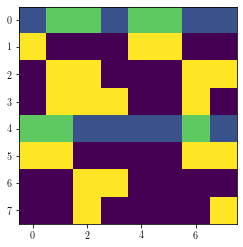

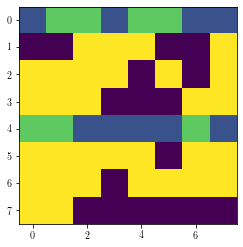

MULTILEVEL


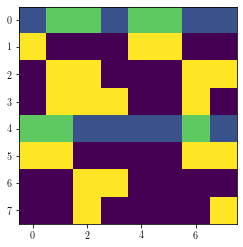

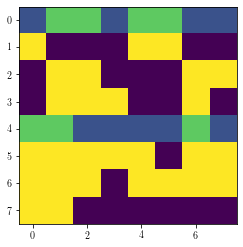

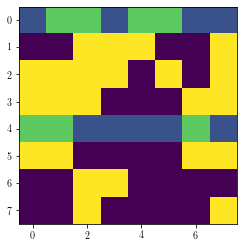

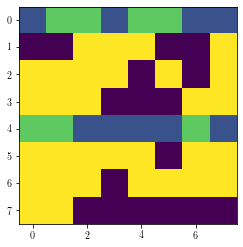

In [26]:
N = 1
M = 2
L = 8
data = multi_slice_ising(L, 0.2, N, M, 2)

spins = data.spins.astype(float)

multilevel_spins = numpy.zeros((N, M, M, L, L))

for i in range(N):
    for j1 in range(M):
        for j2 in range(M):
            # Multilevel spins have all combinations of sublattices
            multilevel_spins[i, j1, j2, :L//2, :] = spins[i, j1, :L//2, :]
            multilevel_spins[i, j1, j2, L//2:, :] = spins[i, j2, L//2:, :]

spins[..., 0, :] = 0.5 * spins[..., 0, :] # To highlight the boundary layer
spins[..., L // 2, :] = 0.5 * spins[..., L // 2, :] # To highlight the boundary layer

print("SINGLEVEL")
for i in range(N):
    for j in range(M):
        plt.imshow(spins[i, j])
        plt.show()
        
print("MULTILEVEL")

# After making multilevel states
multilevel_spins[..., 0, :] = multilevel_spins[..., 0, :] * 0.5 # To highlight the boundary layer
multilevel_spins[..., L//2, :] = multilevel_spins[..., L//2, :] * 0.5 # To highlight the boundary layer
for i in range(N):
    for j1 in range(M):
        for j2 in range(M):
            plt.imshow(multilevel_spins[i, j1, j2])
            plt.show()

This really is the magic of multilevel. We've gone from two configurations to four (two squared) configurations, almost for free. However, all is not what it seems on the surface. If the correlation length is very large, then each configuration will be largely determined by the boundary and so won't be fully independent.

While all estimators of the two-point function have the same mean, they have varying variance and covariance relative to eachother. To quickly define what we mean here, we first average the two-point function over the M^2 subconfigurations produced by multilevel, to get N values (number of different boundary configurations) for each slice coordinate (N x L overall). We can then consider the L x L empirical covariance matrix of this data.

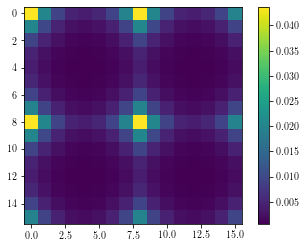

In [27]:
N = 50
M = 50
L = 16
delta = L // 2
beta = 0.35

numpy.random.seed(2123)

data = multi_slice_ising(L, beta, N, M, 2)

# Calculate the twopt function between points seperated by half the lattice size
twopt_data = data.twopt(delta)

cov_matrix = numpy.cov(twopt_data, rowvar=False)

plt.imshow(cov_matrix)
plt.colorbar()
plt.savefig(f"graphs/cov_matrix_N{N}_M{M}_L{L}_delta{delta}.png", dpi=500)
plt.show()

Let's interpret the above. Firstly, let's note that delta is L//2, so half the lattice size, so there is a correlator between the two boundaries. This twopt function is the same accross all M^2 sublattices for each boundary, and so is undersampled. This leads to it having a high variance. The boundaries are located at positions 0 and 4, and so (0,0) in the above is the variance of the first boundary correlator to the second. Similarly with (4, 4).

We see that the covariance is also significant. What is prehaps suprising is that the variance and covariance of points closer to the boundary are higher. This is because these points are influenced by the boundary and therefore vary less when the boundaries are kept fixed.

One thing to note is that the algorithm is symmetric in exchange of the 2 sublattices. We can simplify the covariance using this fact by averaging over the subregions. This is equivalant to taking the top-left corner of the covariance matrix calculated above (or any of the quadrants).

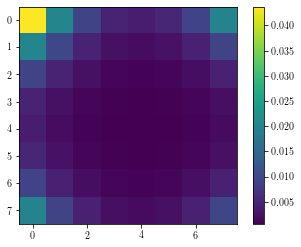

In [28]:
twopt_data = ((twopt_data + numpy.roll(twopt_data, -L//2, axis=1))/2)[:, :L//2]

cov_matrix = numpy.cov(twopt_data, rowvar=False)

plt.imshow(cov_matrix)
plt.colorbar()

Okay great, we can find the covariance matrix - how is this useful exactly?

To see how, we will need some maths. A priori, all of the two-point estimators at each slice coordinate are random variables with a mean given by the true value of the twopt function and some variance. All of these variances/covariances together form a covariance matrix, COV. By averaging over the N boundary configurations and assuming that the central limit theorum holds, then the two-point estimators are individually of the form $N\left(\mu_{phys}, \frac{\sigma^2}{N}\right)$. When we make a weighted average of these estimators, with weight vector $\textbf{w}$, we get a general result of $N\left(\mu_{phys}, \frac{\textbf{w}\cdot COV \cdot \textbf{w}}{N}\right)$.

We therefore get the minimization problem of minimizing $\textbf{w}\cdot COV \cdot \textbf{w}$ with respect to $\textbf{w}$, while maintaining $\sum_x{w(x)} = 1$. This is exactly what the following function does, through the method of Lagrange multipliers.

To do this we will need to use the get_weights function from earlier. This function does exactly this.

In [29]:
get_weights(numpy.cov(twopt_data, rowvar=False))

array([ 0.05341407, -0.25063609, -0.07626991,  0.19675097,  0.70901362,
        0.47556037,  0.02271288, -0.13054591])

Unsuprisingly the method weights the boundary unfavorably (the negative value is a symptom of overfitting - the point is that the value is close to zero). In contrast the site furthest from the boundary gets the highest weight of 0.6



### 2.3. Testing

We're now in a position to study the relative performance of single level vs. multilevel algorithms. We wish to look at the dependence of the performance on the correlation length. So we will use the following function to extract the correlation length from the two-point functions.

In [30]:
def cosh_fit_xi_only(twopt_data, L):
  # Calculate the covarience matrix
  cov = numpy.cov(twopt_data, rowvar=True)

  # Invert the covarience matrix sqrt
  cov_inv = numpy.linalg.inv(cov)

  # Prepare the data for the fitted
  y_s = numpy.mean(twopt_data, axis=1)
  x_s = numpy.arange(0, L // 2 + 1)

  def f(xi, x, y0):
    A = y0 / (1 + numpy.exp(-L / xi))
    return A * (numpy.exp(-x / xi) + numpy.exp(-(L - x) / xi))

  # Define the residuals function
  def chisq(xi):
    unnormalized = y_s - f(xi, x_s, y_s[0])
    return numpy.dot(unnormalized, numpy.dot(cov_inv, unnormalized))

  # Minimize this function
  res = minimize_scalar(chisq, bounds=[0, L], method='bounded')

  xi = res.x

  # 2 d.o.f. because the first entry of twopt is used to determine the constant
  # multiplying the exponential
  n_dof = len(x_s) - 2 # number of degrees of freedom
  
  p_value = chisq_pvalue(n_dof, chisq(xi))

  A = y_s[0] / (1 + numpy.exp(-L / xi))

  return xi, A, p_value

To do this study we need to find the perfomance and correlation length over a range of $\beta$ (temperatures).

In [31]:
def run_twopt_calculations(beta, N, M, L, no_samples=100, Nstep=1, Mstep=20, source_step=20, bin_size=10, rerun=False, seed=0):
    no_deltas = L // 2 + 1
    deltas = numpy.arange(0, no_deltas)
    splitting = 2

    numpy.random.seed(seed)

    directory = template_twopt_calculation(beta, L, N, M, no_samples, Nstep, Mstep, source_step, bin_size, seed, directory=True)
    filename = template_twopt_calculation(beta, L, N, M, no_samples, Nstep, Mstep, source_step, bin_size, seed, directory=False)

    if not rerun:
      if file_exists(directory, filename):
        result = numpy.load(f"{directory}{filename}")
        return result

    results = numpy.zeros((5, no_deltas, no_samples))

    data = multi_slice_ising(L, beta, N, M, splitting, Mstep=Mstep, source_file_step=source_step)

    data_single = single_slice_ising(L, beta, N * M, source_step)

    seed_single = int(numpy.rint((beta - min_beta) * (no_betas - 1) / (max_beta - min_beta)))
    seed_multi = seed_single + no_betas

    for j, delta in enumerate(deltas):
        print(f"Calculating for beta = {beta}, delta = {delta}")
        results[0, j] = data_single.twopt_bootstrap(delta, no_samples, seed=seed_single)
        results[1, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='optimized', bin_size=bin_size)
        results[2, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='naiive', bin_size=bin_size)
        results[3, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='equal', bin_size=bin_size)
        results[4, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='chisq', bin_size=bin_size)

    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", results)
    
    return results

In [32]:
L_s = [16, 32]
N = 500
M = 500
no_samples = 500
no_betas = 32
min_beta = 0.1
max_beta = numpy.log(1 + numpy.sqrt(2)) / 2
no_betas = 32
betas = numpy.linspace(min_beta, max_beta, no_betas)
full_results = {}
rerun = False

def f(beta):
    return run_twopt_calculations(beta, N, M, L, no_samples=no_samples, rerun=rerun)

for L in L_s:
    p = Pool(os.cpu_count())
    full_results[L] = numpy.array(p.map(f, betas))
    p.close()

In [33]:
directory = f'{base_directory}graphs/'

if not os.path.isdir(directory):
  os.makedirs(directory)

# Calculate the correlation length of the system for each beta and L
xis = {}

for L in [16, 32]:
  xis[L] = numpy.zeros(len(betas))

  results = full_results[L]
  print(results.shape)

  for i, beta in enumerate(betas):
    # Use the single level data to calculate the correlation length
    res = cosh_fit_xi_only(results[i, 0, ...], L)
    xis[L][i] = res[0]

(32, 5, 9, 500)
(32, 5, 17, 500)


In [34]:
L = 32
results = full_results[L]
deltas = numpy.arange(L//2 + 1)

# Extract Standard deviations from the results
single_stds = numpy.std(results[:, 0], axis=2)
multi_stds = numpy.std(results[:, 1], axis=2)
multi_naiive = numpy.std(results[:, 2], axis=2)
multi_unw = numpy.std(results[:, 3], axis=2)
multi_chisq = numpy.std(results[:, 4], axis=2)

for delta in deltas:
  plt.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
  plt.scatter(xis[L], (single_stds[:, delta] / multi_naiive[:, delta])[:len(betas)], label='naiive weights', color='b')
  # plt.scatter(xis[L], (single_stds[:, delta] / multi_chisq[:, delta])[:len(betas)], label='chisq', color='g')
  plt.scatter(xis[L], (single_stds[:, delta] / multi_stds[:, delta])[:len(betas)], label='optimized weights', color='g')  
  plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
  plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
  plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

  plt.yscale('log')
  plt.xscale('log')
  ylabel = plt.ylabel(r'$ \frac{\sigma_{s}}{\sigma_{m}} $')
  ylabel.set_rotation('0')
  plt.xlabel(r'$ \xi $')
  plt.title(rf' $ \delta = {delta}, N = {N}, M = {M}, L = {L} $')
  plt.text(0.45, 0.06, r' $ \frac{\sigma_{s}}{\sigma_{m}} = \frac{1}{\sqrt{M}} $ ')
  plt.text(0.45, 15, r' $ \frac{\sigma_{s}}{\sigma_{m}} = \sqrt{M} $ ')
  plt.legend(loc=(0.6, 0.7))
  plt.savefig(f'{directory}gain_vs_xi_delta{delta}.pdf', dpi=500)
  # plt.show()
  plt.close()

Make the a four panel plot for the sake of presenting results

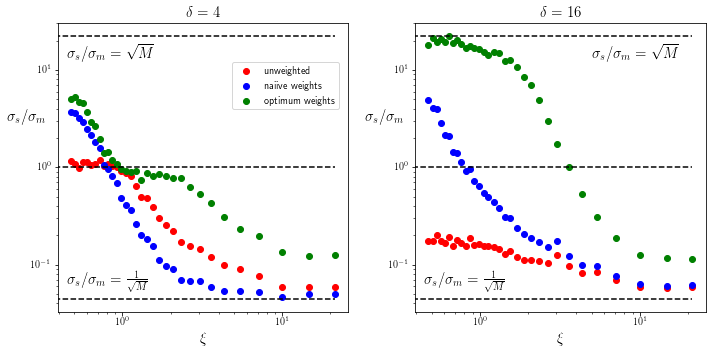

In [35]:
delta_sample = [4, 16]
font_size = 15

# To get as square as possible of a plot
def get_factors(n):
  prime_candidates = primesieve.primes(int(numpy.sqrt(n)) + 1)
  factor_candidates = numpy.array([numpy.product(numpy.array(i)) for i in Powerset.powerset(prime_candidates)[1:]])
  factor_candidates = numpy.sort(factor_candidates[factor_candidates <= int(numpy.sqrt(n)) + 1])

  current_factor = 1
  for factor in factor_candidates:
    if n%factor == 0:
      current_factor = factor

  return n // current_factor, current_factor

subplot_factors = get_factors(len(delta_sample))
subplot_factors = (1, 2)
fig, axes = plt.subplots(*subplot_factors)

for i, delta in enumerate(delta_sample):  
  if len(numpy.array(axes).shape) == 1:
    ax = axes[i]

  else:
    dim_x, dim_y = numpy.array(axes).shape
    ax = axes[i // dim_y, i % dim_y]

  ax.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
  ax.scatter(xis[L], (single_stds[:, delta] / multi_naiive[:, delta])[:len(betas)], label='naiive weights', color='b')
#   ax.scatter(xis[L], (single_stds[:, delta] / multi_chisq[:, delta])[:len(betas)], label='optimum weights', color='g')
  ax.scatter(xis[L], (single_stds[:, delta] / multi_stds[:, delta])[:len(betas)], label='optimum weights', color='g')
  ax.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
  ax.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
  ax.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

  ax.set_title(rf"$\delta = {delta}$", fontsize=font_size)

  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_ylabel(r'$ \sigma_s/\sigma_m$', rotation=0, fontsize=font_size, position=(0.5, 0.65))
  ax.set_xlabel(r"$\xi$", fontsize=font_size)

  if i == 0:
      ax.legend(loc=(0.6, 0.7))
      ax.text(0.45, 0.065, r' $ \sigma_s/\sigma_m = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
      ax.text(0.45, 13.5, r' $ \sigma_s/\sigma_m = \sqrt{M} $ ', fontsize=font_size)
  
  else:
      ax.text(0.45, 0.065, r' $ \sigma_s/\sigma_m = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
      ax.text(5, 13.5, r' $ \sigma_s/\sigma_m = \sqrt{M} $ ', fontsize=font_size)

# plt.suptitle(rf' $ N = {N}, M = {M}, L = {L} $')
fig.set_size_inches((4 * subplot_factors[1] + 2, 3 * subplot_factors[0] + 2))
plt.tight_layout()
plt.savefig(f"{directory}multi_panel_plot.pdf")
plt.show()


I will go through some representative examples now. Firstly consider the $\delta = 0$ correlator. It is impossible for multilevel to offer any imporvements to the error of this correlator, as it doesn't connect two different subregions. Therefore, the best we can hope for from multilevel is to match single level. This is what we see below for small correlation length. As the correlation length increases sublattice configurations become more and more boundary dependent, and the $NM$ independent configurations reduce to just $M$ in the case of multilevel, causing it to perform up to $\frac{1}{\sqrt{M}}$ worse. 

Text(0.5, 0, 'correlation length, xi')

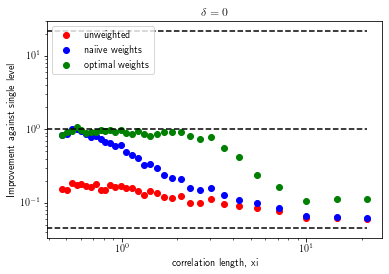

In [36]:
delta = 0

plt.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
plt.scatter(xis[L], (single_stds[:, delta] / multi_naiive[:, delta])[:len(betas)], label='naiive weights', color='b')
plt.scatter(xis[L], (single_stds[:, delta] / multi_chisq[:, delta])[:len(betas)], label='optimal weights', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title(rf' $\delta = {delta} $ ')
plt.ylabel('Improvement against single level')
plt.xlabel('correlation length, xi')

Next we consider the best case scenario for multilevel, where the seperation between the points of the correlator is half the lattice size ($\delta = \frac{L}{2}$). This allows all but the boundary contributions to benefit from multievel as they connect the different subregions. At small correlation lengths, each sublattice configuration has little correaltion to the boundary and so is close to being independent. Therefore, a properly weighted multilevel is able to get close the the optimum scaling improvement, by a factor of $\sqrt{M}$. The unweighted multilevel performs poorly across all correlation lengths, due to the fact that it weights the boundary contribution equally to all other contirubtions. This boundary contribution however has a standard deviation like $\frac{1}{\sqrt{N}}$, as opposed to the non-boundary contributions, which scale like $\frac{1}{NM^2}$. It therefore dominates the error. The naiive weighting scheme fixes this issue, and performs reasonably at very small correaltion lengths. However, as the correaltion length increaes, the sub-lattice sites either side of the boundary become significantly correlated to the boundary, and so aren't independent from sub-lattice sample to sub-lattice sample. Therefore, 

Text(0.5, 0, 'correlation length, xi')

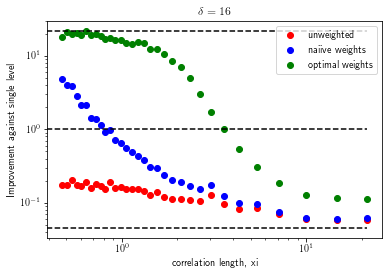

In [37]:
delta = 16

plt.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
plt.scatter(xis[L], (single_stds[:, delta] / multi_naiive[:, delta])[:len(betas)], label='naiive weights', color='b')
plt.scatter(xis[L], (single_stds[:, delta] / multi_chisq[:, delta])[:len(betas)], label='optimal weights', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title(rf' $ \delta = {delta} $ ')
plt.ylabel('Improvement against single level')
plt.xlabel('correlation length, xi')

Intitively we may think that the absolute value of the correlation length isn't important, only its size relative to $L$. We will now test this intuition by looking at $L = 16$ and $L = 32$ data. To be explicit the hypothesis here is that as we send $L \xrightarrow[]{} \alpha L, \delta \xrightarrow[]{} \alpha \delta, \xi \xrightarrow[]{} \alpha \xi$, then the relative performance of multilevel stays about the same.

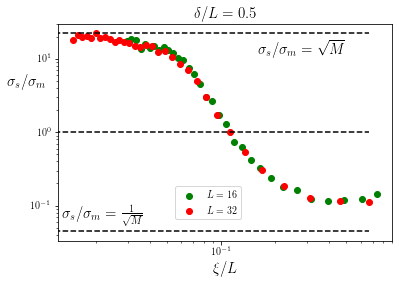

In [38]:
delta_frac = 1 / 2 # delta / L
L_s = [16, 32]
N = 500
M = 500
colors = {16: 'g', 32: 'r'}
font_size = 15

for L in L_s:
    results = full_results[L]

    # Extract Standard deviations from the results
    single_stds = numpy.std(results[:, 0], axis=2)
    multi_chisq = numpy.std(results[:, 4], axis=2)

    delta = int(numpy.rint(delta_frac * L))

    plt.scatter(xis[L] / L, single_stds[:, delta] / multi_chisq[:, delta], label=rf' $ L={L} $ ', color=colors[L])

plt.plot([0, max(xis[L] / L)], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L] / L)], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L] / L)], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$ \xi / L $', fontsize=font_size)
ylabel = plt.ylabel(r'$ \sigma_{s}/\sigma_{m} $', fontsize=font_size, position=(0.3, 0.7))
ylabel.set_rotation('0')
plt.text(0.013, 0.07, r' $ \sigma_{s}/\sigma_{m} = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
plt.text(0.16, 12, r' $ \sigma_{s}/\sigma_{m} = \sqrt{M} $ ', fontsize=font_size)
plt.title(rf'$ \delta / L = {delta_frac} $', fontsize=font_size)
plt.legend(loc=(0.35, 0.1))
plt.savefig(f'{base_directory}/graphs/scaling.pdf')
plt.show()
plt.close()

This is great, it feels like we're really beginning to understand multilevel performance here. Prehaps we can predict it without running a single simulation! That is the topic of the next section.

# 3. Theoretical Model
I will now go through a model for multilevel performance, which makes the following assumptions:

1. Time-slices are random variables correlated to eachother
2. Correlation between time-slices given by twopt function - e.g. $\langle S(t) S(t + \delta) \rangle = Ae^{\frac{-\delta}{\xi}}$.
3. Time-slices in different sub-regions only correlated indirectly via.boundary

This model is conceptually simple, but there is a fair amount of complexity involved in making sure that fields are correlated to eachother by the right amount. This is because the correlation matrix we looked at previously is the result of upto 4 different slice variables: two for each two-point function, of which we need two to calculate the co-variance. The correlation between these sites is described by the upper triangle of a 4x4 correlation matrix (6 unique contributions). The code below implements this, however, it is rather complicated, so if the reader wishes they can skip ahead to the results section. 

## 3.1 Normality of Slice Coordinates

In what is to follow we will treat the slice coordinate variables as normally distributed. This assumption is made due to the central limit theorum as they are an average over $L$ configurations. The larger the lattice size (and also the higher the dimensionality of the lattice) the better this approximation will hold.

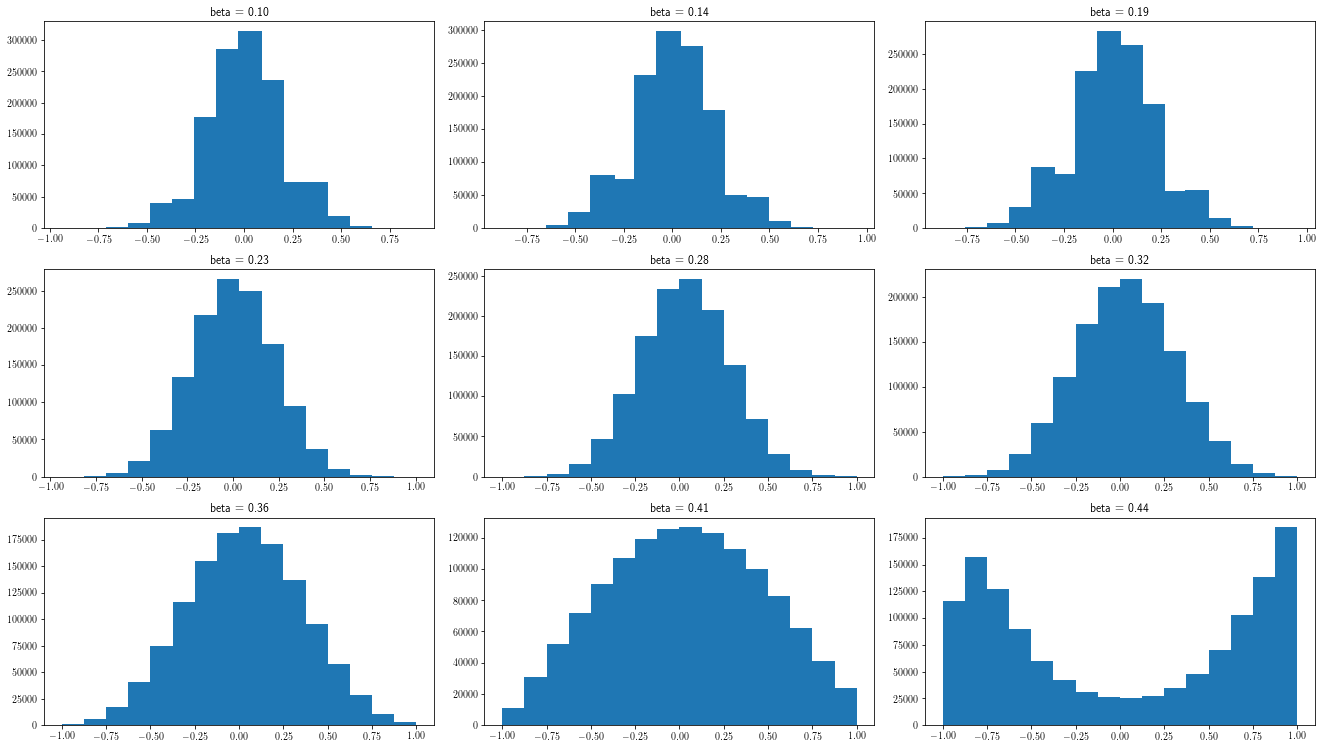

In [39]:
N = 200
M = 200
L = 32
source_step = 20

slice_data = numpy.zeros((no_betas, N * M * L))

for i, beta in enumerate(betas):
    data = single_slice_ising(L, beta, N * M, source_step)
    slice_data[i] = data.spin_slice.reshape(N * M * L)

num_columns = 3
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns)

beta_nos = [0, 4, 8, 12, 16, 20, 24, 28, 31]

for i, beta_no in enumerate(beta_nos):
    data = slice_data[beta_no]
    a, b = numpy.histogram(data, int(L / 2))
    axes[i // num_columns, i % num_columns].bar(b[:-1], a, width=4 / L, align='edge')
    axes[i // num_columns, i % num_columns].title.set_text(f'beta = {betas[beta_no]:.2f}')

fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.savefig("graphs/slice_coordinate_distros.png", dpi=500)
plt.show()

It can be seen that the distribution of the slice coordinate is (as hoped) roughly normal. This falls apart very close to criticality, so it is assumed our model will not perform well there. To try and quantify this use a test of gaussianity.

In [58]:
# slice_sigmas = numpy.zeros(len(betas))

# for i, beta in enumerate(betas):
#     data = slice_data[i]
#     slice_sigmas[i] = numpy.std(data)

# # plt.scatter(xis[L], slice_sigmas)
# # plt.scatter(xis[L], numpy.sqrt((xis[L] / L) + (1 / L)), label='guess')
# # plt.scatter(xis[L], numpy.sqrt((xis[L] / L)) + numpy.sqrt((1 / L)), label='guess')
# # print(numpy.sqrt((xis[L] / L)))
# # print(numpy.sqrt((1 / L)))
# guess2 = numpy.sqrt(1 / L * (1 - numpy.exp(-1 / xis[L]) * (1 - numpy.exp(-L / xis[L])) / (1 - numpy.exp(-1 / xis[L])) ))
# guess3 = numpy.sqrt((xis[L] / (L + xis[L])) + 1 / L)
# guess4 = numpy.sqrt(numpy.maximum(xis[L] / (L + xis[L]), 1 / L))
# guess5 = numpy.sqrt(numpy.sqrt((xis[L] / (L + xis[L])) ** 2 + (1 / L) ** 2))
# guess6 = numpy.sqrt(numpy.sqrt((xis[L] / (numpy.sqrt(L ** 2 + xis[L] ** 2))) ** 2 + (1 / L) ** 2))



# plt.scatter(xis[L], slice_sigmas, label='observed')
# # plt.scatter(xis[L], guess2, label='guess2')
# plt.scatter(xis[L], guess3, label='linear')
# # plt.scatter(xis[L], guess4, label='guess4')
# plt.scatter(xis[L], guess5, label='quadratic')
# plt.scatter(xis[L], guess6, label='quadratic x2')


# fig.set_size_inches(18.5, 10.5)
# plt.tight_layout()
# plt.legend()
# plt.xlabel(r"$\xi$")
# plt.ylabel(r"$\sigma$")

# plt.savefig("graphs/slice_coordinate_sgima.png", dpi=500)
# plt.show()

# plt.scatter(xis[L], slice_sigmas / guess6)
# plt.show()

In [59]:
def normal_expectation(p, sigma=1):
  if p % 2 == 0:
    return factorial2(p - 1) * sigma ** p
  else:
    return 0

def normal_expectation2(p, quart=False):
  if quart:
    if p == 4:
      return 3
    else:
      return 0
  
  else:
    if p == 2:
      return 1
    else:
      return 0

Let's say we have two dictionary objects which count up the number of occurances of different things. We would like a way to combine them in a sort of outer-product style, where the entry with (key1, key2) is given by the sum of the entries dict1(key1) and dict2(key2). I've implemented this function using Counter objects which behave like dictionaries, but have += capabilities.

In [60]:
def Counter_multiplier(counter1, counter2):
  new_counter = Counter()
  for entry1 in counter1:
    for entry2 in counter2:
      if type(entry1) == tuple:
        if type(entry2) == tuple:
          if entry1 + entry2 in new_counter:
            new_counter[entry1 + entry2] += counter1[entry1] * counter2[entry2]
          else:
            new_counter[entry1 + entry2] = counter1[entry1] * counter2[entry2]
        else:
          if entry1 + (entry2,) in new_counter:
            new_counter[entry1 + (entry2, )] += counter1[entry1] * counter2[entry2]
          else:
            new_counter[entry1 + (entry2, )] = counter1[entry1] * counter2[entry2]
      else:
        if type(entry2) == tuple:
          if (entry1,) + entry2 in new_counter:
            new_counter[(entry1,) + entry2] += counter1[entry1] * counter2[entry2]
          else:
            new_counter[(entry1,) + entry2] += counter1[entry1] * counter2[entry2]
        else:
          if (entry1, entry2) in new_counter:
            new_counter[(entry1, entry2)] += counter1[entry1] * counter2[entry2]
          else:
            new_counter[(entry1, entry2)] += counter1[entry1] * counter2[entry2]
  
  return new_counter

The problem with the above method is that it can lead to degeneracies in the output. For example, (key1, key2) can have an entry, but also (key2, key1). This behavior could be desired, however in this case it isn't. The following function brings these entries together into the form of a new key which is in the form of a Counter object. In this example the entry would be Counter({'key1': 1, 'key2': 1}).

I realise this is confusing as I'm using a dictionary as the key for another dictionary. In future iterations of this code this method may be simplified.

In [61]:
def Counter_considator(counter):
  new_counter = Counter()
  total = 0
  for key in counter:
    new_key = frozenset(dict(Counter(key)).items())
    if new_key in new_counter:
      new_counter[new_key] += counter[key]
    else:
      new_counter[new_key] = counter[key]

    extra = numpy.product(numpy.array([normal_expectation(value) for value in Counter(key).values()])) * counter[key]
    total += extra
  
  return new_counter, total

def Counter_considator2(counter):
  new_counter = Counter()
  quad_total = 0
  quart_total = 0

  for key in counter:
    new_key = frozenset(dict(Counter(key)).items())
    if new_key in new_counter:
      new_counter[new_key] += counter[key]
    else:
      new_counter[new_key] = counter[key]

    quad_total += numpy.product(numpy.array([normal_expectation2(value, quart=False) for value in Counter(key).values()])) * counter[key]
    quart_total += numpy.product(numpy.array([normal_expectation2(value, quart=True) for value in Counter(key).values()])) * counter[key]
  
  total = quart_total + quad_total

  return new_counter, total, quad_total, quart_total

The following function calculates the correlation between two slice-variables in this model. It also takes account of around the world effects with the $L- x$ term.

In [62]:
def correlation(x1, x2, xi, L):
  distance = abs(x1 - x2)

  # return numpy.exp(-distance / xi) + numpy.exp(-(L - distance) / xi) - numpy.exp(-distance / xi) * numpy.exp(-(L - distance) / xi)
  return numpy.exp(-distance / xi) + numpy.exp(-(L - distance) / xi)


## 3.2. Correlated field class

In [63]:
class fun_field(object):
  def __init__(self, name, dependants, correlations, N=10, M=10, boundary=False, region=0):
    """
      INPUTS:
      -------
      name: string, describes how this object is represented when printed.
      dependants: list of other fun_field instances, of which this field is dependent - e.g. part of the value of this field is determined from
                  the correlation to these fields.
      correlations: vector of the same length and order as dependants containing the correlations between this field and each of the dependants - these
                    values are between 0 and 1.
      N: int, number of boundary configurations
      M: int, number of sublattice configurations per boundary config
      boundary: bool
      simulate: bool - if true then use numpy.random library to create correlated random variables, if it's false then use theoretical predictions to calculate
                variances
      region: int - the index of the region this field is contained within - see the region_maker function
    """
    self.region = region
    self.boundary = boundary
    self.name = name
    self.dependants = dependants
    self.correlations = {}
    self.N = N
    self.M = M

    # A field is absolutely correlated to itself
    self.correlations[self] = 1

    for i, dependant in enumerate(dependants):
      self.correlations[dependant] = correlations[i]

      # Also set dependants correlations
      dependant.correlations[self] = correlations[i]
   
    # The coefficients describing the relative contributions of this fields random value from itself + its dependents (hence the + 1)
    self.coefficients = numpy.zeros(len(dependants) + 1)

    # This will be used to store values if the field is simulated (with simulate == True)
    self.values = numpy.zeros((N, M))

    # This dictionary gives the contributions of original noise in this random variable - e.g. $X = \sum_i c_i Y_i$, with $Y_i ~ N(0, 1)$, and $c_i$ being the
    # values in self.noise_dict. X here represents this fun field.
    self.noise_dict = Counter({})

    # If there are no dependents then this field is the result of a single random variable, which gets a coefficient of 1.
    if len(dependants) == 0:
      self.coefficients = [1]

    else:
      # Get the coefficients for each of the fields
      coefficient_matrix = numpy.zeros((len(dependants), len(dependants)))

      for i in range(len(dependants)):
        for k in range(len(dependants)):
          coefficient_matrix[i, k] = dependants[i].correlations[dependants[k]]

      # Now solve the correlation equations
      # To understand this, consider a single component of correlations. This component is the correlation of this field to dependent i.
      # It's value however is a sum over all the dependents multiplied by their correlations to dependent i.
      self.coefficients[:-1] = numpy.linalg.solve(coefficient_matrix, correlations)

      # Now lastly need to calculate the remaining random noise in this field that is unnacounted for from correlation to other fields
      for i, dependant in enumerate(self.dependants):
        B = dependant.get_noise_Counter()
        for k in B.keys():
          B[k] = B[k] * self.coefficients[i]

        self.noise_dict = self.noise_dict + B
     
      # The sum of the squares of the coefficients of the $N(0, 1)$ contributions should be 1, to give an overall variance of 1
      sum_squares = sum([self.noise_dict[entry] ** 2 for entry in self.noise_dict])
      self.coefficients[-1] = numpy.sqrt(1 - sum_squares)
    
    self.noise_dict += {self: self.coefficients[-1]}

  # Using the coefficients we've calculated used numpy.random.normal to draw samples of these random distributions.
  def simulate(self):
    if self.boundary:
      self.values = self.coefficients[-1] * numpy.random.normal(size=self.N).reshape((self.N, 1)).repeat(self.M, axis=1)

    else:
      self.values = self.coefficients[-1] * numpy.random.normal(size=(self.N, self.M))

    # Give the field values
    for i, dependant in enumerate(self.dependants):
      self.values += self.coefficients[i] * dependant.values

  def get_noise_Counter(self):
    """
      This function returns a Counter object where each entry is a fun_field name, with the associated value being the contribution of that fields random noise
      to this field.
    """    
    A = Counter({self: self.coefficients[-1]})

    for i, dependant in enumerate(self.dependants):
      B = dependant.get_noise_Counter()
      for k in B.keys():
        B[k] = B[k] * self.coefficients[i]
      A += B
    
    return A

  def __str__(self):
    return self.name

  def __repr__(self):
    return self.name

We can now use this class representing a single field insertion to build up correlators of field insertions. To calculate the covariance matrix that we have used prevsiously we need four field insertions - two for each correlator, plus field insertions for the boundary layers. The following class is designed for this specific task

The covariance between two two-point correlators is given by $Cov(C_2(x_1), C_2(x_2)) = \langle C(x_1) C(x_2) \rangle - \langle C(x_1) \rangle \langle C(x_2) \rangle = \langle \phi(x_1) \phi(x_1 + \delta) \phi(x_2) \phi(x_2 + \delta) \rangle - \left(\exp(-\frac{\delta}{\xi})\right)^2$

In [64]:
class two_correlators(object):
  """
    Extending correlator to take in 4 fields to give 2 correlators
  """
  def __init__(self, x1, x2, delta, xi, L, N=10, M=10, multi=True):
    """
      INPUTS:
      -------
      x1: int, location of first correlator
      x2: int, location of second correlator
      delta: int, seperation between points in each correlator
      xi: float, correlation length
      L: int, lattice size
      N: int, number of boundary configurations
      M: int, number of sublattice configurations
      multi: bool, calculate correlations assuming a multilevel simulation. If False then will assume N * M single level configurations
    """
    self.delta = delta
    self.L = L
    self.N = N
    self.M = M
    self.xi = xi
    self.multi = multi
    self.x1 = x1
    self.x2 = x2
    self.x_s = numpy.array([x1, x2, (x1 + delta) % L, (x2 + delta) % L])
    self.regions = numpy.where(self.x_s >= L // 2, 2, 1)
    self.phi1 = None # at x1
    self.phi2 = None # at x2
    self.phi1_ = None # (at x1 + delta)
    self.phi2_ = None # (at x2 + delta)
    self.fields = [self.phi1, self.phi2, self.phi1_, self.phi2_]

    if multi:
      # Add the boundaries - first boundary is uncorrelated - second is correlated to the first
      self.boundary1 = fun_field("B1", [], [], N=N, M=M, boundary=True)
      self.boundary2 = fun_field("B2", [self.boundary1], [correlation(0, L / 2, xi, L)], N=N, M=M, boundary=True)

      # Points in each region are only correlated to the boundaries and fields within that region. Any dependence on the other subregions
      # occurs via. correlation to the boundary.
      for region in [1, 2]:
        dependant_xs = [0, L // 2]
        dependants_old = [self.boundary1, self.boundary2]
        dependants_new = dependants_old

        for i in numpy.argwhere(self.regions == region)[:, 0]:
          x = self.x_s[i]

          if x in dependant_xs:
            # This means we already have a field at this site, so just use that field
            self.fields[i] = dependants_new[numpy.argwhere(numpy.array(dependant_xs) == x)[0][0]]

          else:
            dependants_old = dependants_new

            # Correlate the new field to the other fields we have in the system
            correlations = [correlation(x, j, xi, L) for j in dependant_xs]

            self.fields[i] = fun_field(f"phi{x}", dependants_old, correlations, N=N, M=M, region=region)

            # Update depenedents
            dependant_xs.append(x)
            dependants_new = dependants_old + [self.fields[i]]

    else: # If single level then there are no boundaries - correlate all fields together.
      dependant_xs = []
      dependants_old = []
      dependants_new = dependants_old
  
      for i in range(4):
        x = self.x_s[i]

        if x in dependant_xs:
          self.fields[i] = dependants_new[numpy.argwhere(numpy.array(dependant_xs) == x)[0][0]]

        else:
          dependants_old = dependants_new
          correlations = [correlation(x, j, xi, L) for j in dependant_xs]
  
          self.fields[i] = fun_field(f"phi{x}", dependants_old, correlations, N=N * M, M=1)
  
          dependant_xs.append(x)
          dependants_new = dependants_old + [self.fields[i]]

  def simulate(self):
    """
      Use numpy.random module to draw random gaussian numbers in order to simulate these fields
    """
    for i in range(4):
      self.fields[i].simulate()

    if self.multi:
        # Depending on whether the two fields are in diferrent regions or not apply multilevel method
        if self.regions[0] != self.regions[2]:
          self.correlator1 = numpy.zeros(N)
          for i in range(N):
            self.correlator1[i] = numpy.mean(numpy.outer(self.fields[0].values[i], self.fields[2].values[i]))
          
        else:
          self.correlator1 = numpy.mean(self.fields[0].values * self.fields[2].values, axis=1)

        if self.regions[1] != self.regions[3]:
          self.correlator2 = numpy.zeros(N)

          for i in range(N):
            self.correlator2[i] = numpy.mean(numpy.outer(self.fields[1].values[i], self.fields[3].values[i]))
          
        else:
          self.correlator2 = numpy.mean(self.fields[1].values * self.fields[3].values, axis=1)

    else:
      self.correlator1 = (self.fields[0].values * self.fields[2].values)[:, 0]
      self.correlator2 = (self.fields[1].values * self.fields[3].values)[:, 0]

  def estimate_covariance(self):
    # Do the easy case first
    if not self.multi:
      # First calculate the trickier 4 point function
      contributions = self.fields[0].noise_dict

      for field in self.fields[1:]:
        contributions = Counter_multiplier(contributions, field.noise_dict)

      # Consilidate the contributions
      contributions, total = Counter_considator(contributions)

    else:
      # Now the hard case! seperate field noise into boundary, region1 and region2 - do this for each field insertion
      field_contributions = (({}, {}, {}), ({}, {}, {}), ({}, {}, {}), ({}, {}, {}))

      for i in range(4):
        for field in self.fields[i].noise_dict:
          if field.boundary == True:
            field_contributions[i][0][field] = self.fields[i].noise_dict[field]

          else:
            field_contributions[i][field.region][field] = self.fields[i].noise_dict[field]

      correlator_noises = [[{}, {}, {}, {}], [{}, {}, {}, {}]]
  
      for i in range(2):
        correlator_noise = correlator_noises[i]
        field_x = field_contributions[i]
        field_y = field_contributions[i + 2]

        # The first part involves multiplying the boundaries - pretty easy
        correlator_noise[0] = Counter_multiplier(field_x[0], field_y[0])

        # Next part involves multiplying the bounaries with the non-bonudaries, at
        # the same time picking up a factor of 1 / sqrt(M), due to the M independent subconfigurations. Note that
        # the effect of the fields being correlated to the boundary has already beeing accounted for in the above term.
        correlator_noise[1] = Counter_multiplier(field_x[0], field_y[1])\
                            + Counter_multiplier(field_x[0], field_y[2])\
                            + Counter_multiplier(field_x[1], field_y[0])\
                            + Counter_multiplier(field_x[2], field_y[0])

        for key in correlator_noise[1]:
          correlator_noise[1][key] = correlator_noise[1][key] / numpy.sqrt(self.M)

        # Next part involves multiplying the region 1 values from one field with the region2
        # values from the second - this is true multilevel, and this contribution picks up a factor of 1 / M
        correlator_noise[2] = Counter_multiplier(field_x[1], field_y[2])\
                            + Counter_multiplier(field_x[2], field_y[1])

        for key in correlator_noise[2]:
          correlator_noise[2][key] = correlator_noise[2][key] / self.M

        # The next part is the most complex and involves the chisq contributions, which
        # are seperated into 2 contributions - one which involves seperable chisq contributions
        # which may be summarised by a single new random variable, and the second contribution
        # which will lead to quartic interactions
        correlator_noise[3] = Counter_multiplier(field_x[1], field_y[1])\
                            + Counter_multiplier(field_x[2], field_y[2])

      ## Okay now we are ready to combine these contributions
      correlator1_noise, correlator2_noise = correlator_noises

      # First term involves boundary only terms and the non-chisq terms times into themselves
      term1 = Counter_multiplier(correlator1_noise[0] + correlator1_noise[1] + correlator1_noise[2],
                                 correlator2_noise[0] + correlator2_noise[1] + correlator2_noise[2])
      term1_number = Counter_considator(term1)[1]

      # Second term involves the boundary only terms and the chisq terms
      term2 = Counter_multiplier(correlator1_noise[0], correlator2_noise[3]) +\
              Counter_multiplier(correlator1_noise[3], correlator2_noise[0])
      term2_number = Counter_considator(term2)[1]

      # Imagine indexing sub-configurations by phi[i, j], where i indexes the boundary configuration and j indexes the sublattice configuration.
      # The random contributions at different j values only have a chisq contribution due to interaction with the boundary.
      term3_number = ((self.M * (self.M - 1)) / self.M ** 2) * Counter_considator(correlator1_noise[3])[1] * Counter_considator(correlator2_noise[3])[1]
      # Prefactor since there are only M(M - 1) possible ways of getting different j and each correlator has a (1 / M factor)

      # Now we add the "same j" contributions from the chisq term
      term4 = Counter_multiplier(correlator1_noise[3], correlator2_noise[3])
      term4_number = Counter_considator(term4)[1] / self.M  # Since there are only M possible ways of getting equal j and each correlator has a (1 / M factor)

      total = term1_number + term2_number + term3_number + term4_number

      # if self.x1 == 5 and self.x2 == 8:
      #   print("")
      #   print("OLD METHOD:")
      #   print(f"Term1 : {term1_number}")
      #   print(f"Term2 : {term2_number}")
      #   print(f"Term3 : {term3_number}")
      #   print(f"Term4 : {term4_number}")

    # In both the single level and multilevel cases remove the disconnected part
    return total - correlation(self.x1, self.x1 + self.delta, self.xi, self.L) ** 2

  def estimate_covariance2(self):
    # Do the easy case first
    if not self.multi:
      # First calculate the trickier 4 point function
      contributions = self.fields[0].noise_dict

      for field in self.fields[1:]:
        contributions = Counter_multiplier(contributions, field.noise_dict)

      # Consilidate the contributions
      contributions, total = Counter_considator(contributions)

    else:
      # Now the hard case! seperate field noise into boundary, region1 and region2 - do this for each field insertion
      field_contributions = (({}, {}, {}), ({}, {}, {}), ({}, {}, {}), ({}, {}, {}))

      for i in range(4):
        for field in self.fields[i].noise_dict:
          if field.boundary == True:
            field_contributions[i][0][field] = self.fields[i].noise_dict[field]

          else:
            field_contributions[i][field.region][field] = self.fields[i].noise_dict[field]

      correlator_noises = [[{}, {}, {}, {}, {}], [{}, {}, {}, {}, {}]]
  
      for i in range(2):
        correlator_noise = correlator_noises[i]
        field_x = field_contributions[i]
        field_y = field_contributions[i + 2]

        # The first part involves multiplying the boundaries - pretty easy
        correlator_noise[0] = Counter_multiplier(field_x[0], field_y[0])

        # Next part involves multiplying the bounaries with the non-bonudaries
        correlator_noise[1] = Counter_multiplier(field_x[0], field_y[1])\
                            + Counter_multiplier(field_x[0], field_y[2])\
                            + Counter_multiplier(field_x[1], field_y[0])\
                            + Counter_multiplier(field_x[2], field_y[0])


        # Next part involves multiplying the region 1 values from one field with the region2
        correlator_noise[2] = Counter_multiplier(field_x[1], field_y[2])\
                            + Counter_multiplier(field_x[2], field_y[1])

        # Field self interactions within a single region - keep regions seperate
        correlator_noise[3] = Counter_multiplier(field_x[1], field_y[1])
        correlator_noise[4] = Counter_multiplier(field_x[2], field_y[2])

      ## Now we are ready to combine these contributions
      correlator1_noise, correlator2_noise = correlator_noises

      # Purely Boundary interactions
      term1 = Counter_multiplier(correlator1_noise[0], correlator2_noise[0])
      term1_number = Counter_considator(term1)[1]

      # Boundary and self-interaction contribution
      term2 = Counter_multiplier(correlator1_noise[0], correlator2_noise[3]) +\
              Counter_multiplier(correlator1_noise[0], correlator2_noise[4]) +\
              Counter_multiplier(correlator1_noise[3], correlator2_noise[0]) +\
              Counter_multiplier(correlator1_noise[4], correlator2_noise[0])
      term2_number = Counter_considator(term2)[1]
      
      # Two mixed boundary - field interactions. Pick up a factor of 1 / M as
      # of the M^2 possibilities for the sub-region indicies to run over, only
      # j = j' contributions count - of which there are M
      term3 = Counter_multiplier(correlator1_noise[1], correlator2_noise[1])
      term3_number = Counter_considator(term3)[1] / self.M

      # Multilevel contribution with two-sets of mixed region correlators. Pick
      # up a factor of 1 / M^2.
      term4 = Counter_multiplier(correlator1_noise[2], correlator2_noise[2])
      term4_number = Counter_considator(term4)[1] / self.M ** 2

      # two self-interactions from different regions.
      term5 = Counter_multiplier(correlator1_noise[3], correlator2_noise[4]) +\
              Counter_multiplier(correlator1_noise[4], correlator2_noise[3])
      term5_number = Counter_considator(term5)[1]

      # two self-interatctions from the same region - this has a quadratic
      # part and a quartic part
      term6 = Counter_multiplier(correlator1_noise[3], correlator2_noise[3]) +\
              Counter_multiplier(correlator1_noise[4], correlator2_noise[4])
      term6_quad, term6_quart = Counter_considator2(term6)[2], Counter_considator2(term6)[3]
      
      term6_number = term6_quad + (2 / self.M) * term6_quart

      total = term1_number + term2_number + term3_number + term4_number + term5_number + term6_number

      # if self.x1 == 5 and self.x2 == 8:
      #   print("")
      #   print("NEW METHOD:")
      #   print(f"Term1: {term1_number}")
      #   print(f"Term2: {term2_number}")
      #   print(f"Term3: {term3_number}")
      #   print(f"Term4: {term4_number}")
      #   print(f"Term5: {term5_number}")
      #   print(f"Term6: {term6_number}")


    # In both the single level and multilevel cases remove the disconnected part
    return total - correlation(self.x1, self.x1 + self.delta, self.xi, self.L) ** 2

Since we can now calculate the individual components of correlation matrices, it is trivial to calculate the whole matrix by itereting over the components. We can do this using the theoretical model, or by sampling the normal distributions with the numpy.random module

In [65]:
def get_cov_matrix(xi, L, delta, N=100, M=100, multi=True, simulate=False, ver=1):
  if delta == L // 2:
    cov_matrix = numpy.zeros((L // 2, L // 2))

    for x1 in range(L // 2):
      for x2 in range(L // 2):
        A = two_correlators(x1, x2, delta, xi, L, N=N, M=M, multi=multi)

        if simulate:
          A.simulate()
          cov_matrix[x1, x2] = numpy.mean(A.correlator1 * A.correlator2) - numpy.mean(A.correlator1) * numpy.mean(A.correlator2)
      
        else:
          if ver == 1:
            cov_matrix[x1, x2] = A.estimate_covariance()
          elif ver == 2:
            cov_matrix[x1, x2] = A.estimate_covariance2()

  else:
    cov_matrix = numpy.zeros((L, L))
  
    for x1 in range(L):
      for x2 in range(L):
        A = two_correlators(x1, x2, delta, xi, L, N=N, M=M, multi=multi)

        if simulate:
          A.simulate()
          cov_matrix[x1, x2] = numpy.mean(A.correlator1 * A.correlator2) - numpy.mean(A.correlator1) * numpy.mean(A.correlator2)
      
        else:
          if ver == 1:
            cov_matrix[x1, x2] = A.estimate_covariance()
          elif ver == 2:
            cov_matrix[x1, x2] = A.estimate_covariance2()

  return cov_matrix

We now have everything we need to calculate the best performance increase we can hope for from multilevel! This of course depends on the lattice size, the two-point seperation and the correlation length.

In [66]:
def get_var_single(xi, L, delta, N=500, M=500, simulate=False, ver=1):
  cov_single = get_cov_matrix(xi, L, delta, N=N, M=M, multi=False, simulate=simulate, ver=ver) / (N * M)

  if delta == L // 2:
    weights_single = numpy.ones(L // 2) / (L // 2)
  
  else:
    weights_single = numpy.ones(L) / (L)

  var_single = numpy.dot(weights_single, numpy.dot(cov_single, weights_single))
  
  return var_single


In [67]:
def get_var_multi(xi, L, delta, N=500, M=500, simulate=False, ver=1):
  cov_multi = get_cov_matrix(xi, L, delta, N=N, M=M, simulate=simulate, ver=ver) / N

  weights_multi = get_weights(cov_multi)

  var_multi = numpy.dot(weights_multi, numpy.dot(cov_multi, weights_multi))

  return var_multi

In [68]:
def gain(xi, L, delta, N=500, M=500, simulate=False, ver=1):
  var_single = get_var_single(xi, L, delta, N=N, M=M, simulate=simulate, ver=ver)

  var_multi = get_var_multi(xi, L, delta, N=N, M=M, simulate=simulate, ver=ver)

  return numpy.sqrt(var_single / var_multi)

In [69]:
gain(0.1, 16, 8, N=50, M=100, simulate=False, ver=1)

9.35420973389896

In [70]:
gain(0.1, 16, 8, N=50, M=100, simulate=False, ver=2)

9.35420973389896

# 4. Testing

To test whether our model works, we need to be able to calculate the correlation length in a system. To do this we will use a cosh fit.

In [71]:
Theoretical = numpy.zeros(len(betas))
N = 500
M = 500
delta = 16
L = 32
numpy.random.seed(232923)

# Use the results we calculated in the previous section
results = full_results[L]

# Extract Standard deviations from the results
single_stds = numpy.std(results[:, 0, delta], axis=1)
multi_stds = numpy.std(results[:, 4, delta], axis=1)

single_stds_theory = numpy.zeros_like(single_stds)
# multi_stds_theory = numpy.zeros_like(multi_stds)
multi_stds_theory = numpy.zeros_like(multi_stds)

for i, beta in enumerate(betas):
    print(f"{beta}")
    xi = xis[L][i]
    try:
        single_stds_theory[i] = numpy.sqrt(get_var_single(xi, L, delta, N=N, M=M, simulate=False))
        multi_stds_theory[i] = numpy.sqrt(get_var_multi(xi, L, delta, N=N, M=M, simulate=False, ver=2))
    except FloatingPointError:
        single_stds_theory[i] = numpy.nan
        multi_stds_theory[i] = numpy.nan
    # multi_stds_theory[i] = numpy.sqrt(get_var_multi(xi, L, delta, N=N, M=M, simulate=False))


0.1
0.11098989656483134
0.12197979312966269
0.13296968969449402
0.14395958625932537
0.15494948282415671
0.16593937938898803
0.17692927595381938
0.1879191725186507
0.19890906908348205
0.2098989656483134
0.22088886221314474
0.23187875877797606
0.2428686553428074
0.25385855190763873
0.2648484484724701
0.2758383450373014
0.28682824160213277
0.2978181381669641
0.3088080347317954
0.3197979312966268
0.3307878278614581
0.34177772442628945
0.3527676209911208
0.3637575175559521
0.3747474141207835
0.3857373106856148
0.3967272072504462
0.4077171038152775
0.4187070003801088
0.4296968969449402
0.44068679350977147


In [74]:
# plt.scatter(xis[L][:-5], numpy.log(single_stds), label='Observered')
# plt.scatter(xis[L][:-5], numpy.log(single_stds_theory * slice_sigmas[:-5] ** 2), label='Theory')
# plt.title('single level')
# plt.legend()
# plt.show()

# plt.scatter(xis[L][:-5], numpy.log(multi_stds), label='Observered')
# plt.scatter(xis[L][:-5], numpy.log(multi_stds_theory * slice_sigmas[:-5] ** 2), label='Theory')
# plt.scatter(xis[L][:-5], numpy.log(multi_stds_theory2 * slice_sigmas[:-5] ** 2), label='Theory2')
# plt.title('multi level')
# plt.legend()
# plt.show()

# plt.scatter(xis[L][:-5], numpy.log(multi_stds / single_stds), label='Observered')
# plt.scatter(xis[L][:-5], numpy.log(multi_stds_theory / single_stds_theory), label='Theory')
# plt.scatter(xis[L][:-5], numpy.log(multi_stds_theory2 / single_stds_theory), label='Theory2')
# plt.title('ratio')
# plt.legend()
# plt.show()

32


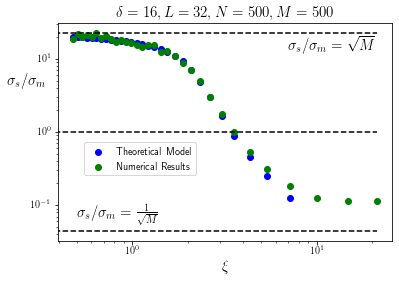

In [76]:
# Theoretical = numpy.zeros(len(betas))
N = 500
M = 500
L = 32
delta = 16
fontsize = 15

# Use the results we calculated in the previous section
results = full_results[L]

# # Extract Standard deviations from the results
# single_stds = numpy.std(results[:, 0], axis=2)
# multi_chisq = numpy.std(results[:, 4], axis=2)

# for i, beta in enumerate(betas):
#     print(f"{beta}")
#     xi = cosh_fit_xi_only(results[i, 0, ...], L)[0]
#     print(f"{xi}")
#     try:
#         Theoretical[i] = gain(xi, L, delta, N=N, M=M, ver=2)
#     except FloatingPointError:
#         Theoretical[i] = numpy.nan
print(len(xis[L]))

plt.scatter(xis[L], (single_stds_theory / multi_stds_theory), label='Theoretical Model', color='b')
plt.scatter(xis[L], (single_stds / multi_stds)[:len(betas)], label='Numerical Results', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.title(rf' $ \delta = {delta}, L = {L}, N = {N}, M = {M} $ ', fontsize=fontsize)
plt.ylabel(r'$ \sigma_{s}/\sigma_{m} $', rotation=0, fontsize=fontsize, position=(0.3, 0.7))
plt.xlabel(r' $ \xi $', fontsize=fontsize)
plt.text(0.5, 0.07, r' $ \sigma_{s}/\sigma_{m} = \frac{1}{\sqrt{M}} $ ', fontsize=fontsize)
plt.text(7, 13, r' $ \sigma_{s}/\sigma_{m} = \sqrt{M} $ ', fontsize=fontsize)
plt.legend(loc=(0.08, 0.3))
plt.savefig(f'{base_directory}/graphs/theoretical_vs_observed.pdf')
plt.show()